<div style="background-color: #a83d36; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px 15px 5px 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h1 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 32px;">Driver Drowsiness Detector-CNN</h1>
</div>


![Image Description](Images/gif.gif)


<div style="background-color: #000000; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0);">
  <h2 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold;">BUSINESS UNDERSTANDING</h2>
</div>

<font size="4">

Driver drowsiness detection technology is crucial for preventing accidents caused by fatigue. Studies show that up to 20% of road accidents are fatigue-related, rising to 50% on certain routes. Implementing this technology not only enhances safety but also boosts market competitiveness, reduces insurance costs, and demonstrates corporate responsibility, aligning with safety goals and offering strategic advantages in the automotive sector.


The aim of this is system to reduce the number of accidents on the road by detecting the drowsiness of the driver and warning them using an alarm.

</font>


<div style="background-color: #000000; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0);">
  <h2 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold;">TABLE OF CONTENTS</h2>
</div>

[1. DATA EXPLORATION](#-1-DATA-EXPLORATION)

[2. DATA PREPROCESSING](#2-DATA-PREPROCESSING)

[3. DATA AUGMENTATION](#4-DATA-AUGMENTATION)

[4. MODEL ARCHITECTURE AND TRAINING](#4-MODEL-ARCHITECTURE)

[5. EVALUATING MODEL PERFORMANCES](#5-Evaluating-Model-Performances)

[7. PREDICTIONS](#7-PREDICTIONS)

[8. CONCLUSION](#8-CONCLUSION)

[9. THANKYOU](#9-THANKYOU)



In [111]:
#import packages

import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image , display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import classification_report



<div style="background-color: #000000; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0);">
  <h2 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold;">DATA EXPLORATION</h2>
</div>


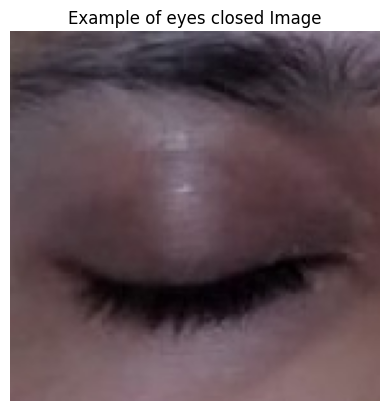

In [112]:
# eyes closed 

plt.imshow(plt.imread(r"train/Closed/_0.jpg"))
plt.title('Example of eyes closed Image')
plt.axis('off')
plt.show()

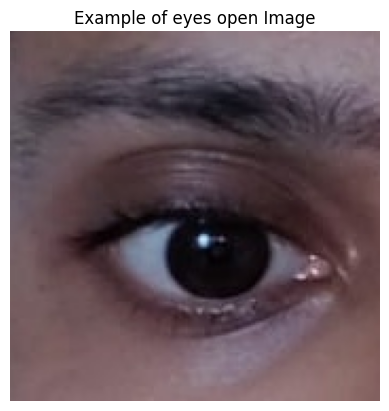

In [113]:
# eyes open 

plt.imshow(plt.imread(r"train/open/_0.jpg"))
plt.title('Example of eyes open Image')
plt.axis('off')
plt.show()

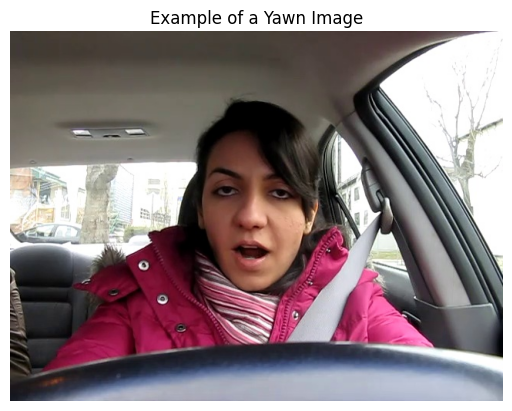

In [114]:
# Yawn 

plt.imshow(plt.imread(r"train/yawn/10.jpg"))
plt.title('Example of a Yawn Image')
plt.axis('off')
plt.show()

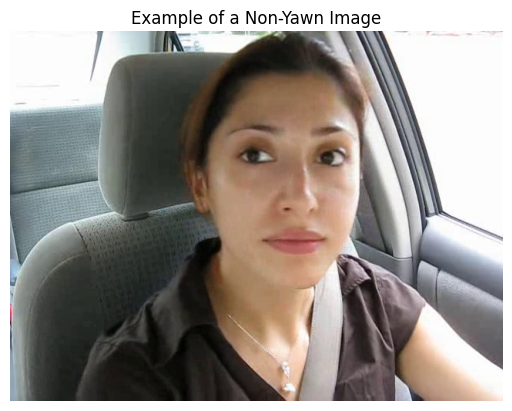

In [115]:
# non-Yawn

plt.imshow(plt.imread(r"train/no_yawn/9.jpg"))
plt.title('Example of a Non-Yawn Image')
plt.axis('off')
plt.show()

<div style="background-color: #000000; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0);">
  <h2 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold;">DATA PREPROCESSING</h2>
</div>

In [116]:
# Detects faces in images and categorizes them as yawn or non-yawn.

def face_for_yawn(direc=r"train", face_cas_path=r"haarcascade_frontalface_default.xml"):
    
    """
    Args:
    - direc (str): Directory path containing image data.
    - face_cas_path (str): Path to the Haar cascade XML file for face detection.

    Returns:
    - yaw_no (list): List of tuples containing resized face images and their corresponding class labels.
    
    """
    
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


In [117]:
# Loads and preprocesses image data for eye state classification


def get_data(dir_path=r"train", face_cas=r"haarcascade_frontalface_default.xml", eye_cas=r"haarcascade.xml"):
    
    """
    Args:
    - dir_path (str): Directory path containing image data.
    - face_cas (str): Path to the Haar cascade XML file for face detection.
    - eye_cas (str): Path to the Haar cascade XML file for eye detection.

    Returns:
    - data (list): List of tuples containing resized image arrays and their corresponding class labels.
    
    """
    
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [118]:
# Combine Face-Detected and Preprocessed Image Data

def append_data():
    
    """
    Returns:
    - new_data (numpy.ndarray): Array containing combined image data and class labels.
    
    """

    yaw_no = face_for_yawn()
    data = get_data()
    new_data= yaw_no + data
    return np.array(new_data, dtype=object)



In [119]:
# Combine face-detected and preprocessed image data to create a new dataset

new_data = append_data()


<div style="background-color: #000000; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0);">
  <h2 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold;">DATA AUGMENTATION </h2>
</div>

In [120]:
# Initialize empty lists to store features (X) and labels (y)
X = []
y = []


# Iterate through each entry in the new_data
for feature, label in new_data:
    # Append the feature (image array) to the X list
    X.append(feature)
    # Append the label to the y list
    y.append(label)

# Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape the feature array to match the required input shape for the model
X = X.reshape(-1, 145, 145, 3)

In [121]:
# Initialize a LabelBinarizer object to encode categorical labels as one-hot vectors
label_bin = LabelBinarizer()

# Fit the LabelBinarizer to the labels and transform them into one-hot encoded vectors
y = label_bin.fit_transform(y)


In [122]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30)

# Print the lengths of the training and testing sets
print("Length of X_train:", len(X_train))
print("Length of X_test:", len(X_test))
print("Length of y_train:", len(y_train))
print("Length of y_test:", len(y_test))


Length of X_train: 1347
Length of X_test: 578
Length of y_train: 1347
Length of y_test: 578


In [123]:
# Data augmentation for training set: rescaling, zooming, horizontal flipping, and rotation
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)

# Data augmentation for testing set: only rescaling
test_generator = ImageDataGenerator(rescale=1/255)

# Create data generators for training and testing sets
train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)


<div style="background-color: #000000; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0);">
  <h2 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold;">MODEL ARCHITECTURE AND TRAINING </h2>
</div>

In [124]:
# Define a Sequential model
model = Sequential()

# Add a convolutional layer with 256 filters, each with a 3x3 kernel, ReLU activation, and input shape of (145,145,3)
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))

# Add a max pooling layer with a 2x2 pool size
model.add(MaxPooling2D(2, 2))

# Add another convolutional layer with 128 filters and a 3x3 kernel, ReLU activation
model.add(Conv2D(128, (3, 3), activation="relu"))

# Add another max pooling layer
model.add(MaxPooling2D(2, 2))

# Add another convolutional layer with 64 filters and a 3x3 kernel, ReLU activation
model.add(Conv2D(64, (3, 3), activation="relu"))

# Add another max pooling layer
model.add(MaxPooling2D(2, 2))

# Add another convolutional layer with 32 filters and a 3x3 kernel, ReLU activation
model.add(Conv2D(32, (3, 3), activation="relu"))

# Add another max pooling layer
model.add(MaxPooling2D(2, 2))

# Flatten the output to a 1D array
model.add(Flatten())

# Add a dropout layer with a dropout rate of 0.5
model.add(Dropout(0.5))

# Add a dense (fully connected) layer with 64 units and ReLU activation
model.add(Dense(64, activation="relu"))

# Add the output layer with 4 units (for the 4 classes) and softmax activation
model.add(Dense(4, activation="softmax"))

# Compile the model with categorical crossentropy loss, accuracy metrics, and Adam optimizer
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Display the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 71, 71, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 34, 34, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 64)       

In [125]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 162s 4s/step - loss: 1.0814 - accuracy: 0.4818 - val_loss: 0.8229 - val_accuracy: 0.7024
Epoch 2/50
43/43 [==============================] - 143s 3s/step - loss: 0.5506 - accuracy: 0.7773 - val_loss: 0.4095 - val_accuracy: 0.8495
Epoch 3/50
43/43 [==============================] - 137s 3s/step - loss: 0.3686 - accuracy: 0.8486 - val_loss: 0.3233 - val_accuracy: 0.8685
Epoch 4/50
43/43 [==============================] - 138s 3s/step - loss: 0.3124 - accuracy: 0.8649 - val_loss: 0.2845 - val_accuracy: 0.8927
Epoch 5/50
43/43 [==============================] - 129s 3s/step - loss: 0.3117 - accuracy: 0.8745 - val_loss: 0.2734 - val_accuracy: 0.8979
Epoch 6/50
43/43 [==============================] - 128s 3s/step - loss: 0.2568 - accuracy: 0.9005 - val_loss: 0.2357 - val_accuracy: 0.9118
Epoch 7/50
43/43 [==============================] - 134s 3s/step - loss: 0.2699 - accuracy: 0.8931 - val_loss: 0.3308 - val_accuracy: 0.8512
Epoch 8/50
43

In [126]:
# Save Model
model.save("Watchdog.h5")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




<div style="background-color: #000000; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0);">
  <h2 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold;">EVALUATING MODEL PERFORMANCES </h2>
</div>

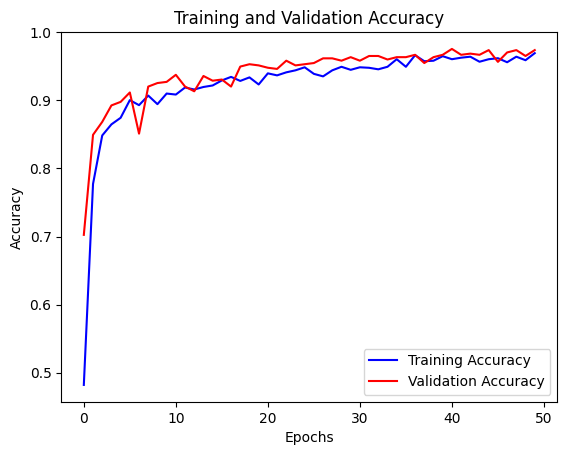

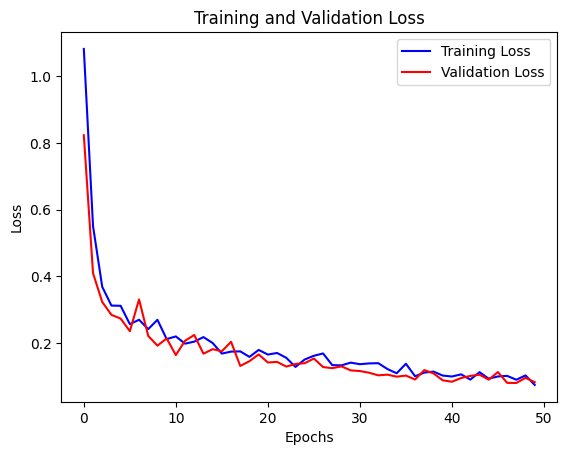

In [137]:
# Extracting training metrics from history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Generate a range of epochs
epochs = range(len(accuracy))

# Plotting training and validation accuracy over epochs
plt.plot(epochs, accuracy, "b", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation Accuracy")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

# Plotting training and validation loss over epochs
plt.plot(epochs, loss, "b", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()


In [139]:
training_accuracy = accuracy[-1]
training_loss = loss[-1]


# Print the training accuracy and loss.
print(f'Training Accuracy of Watchdog Model : {training_accuracy * 100:.2f} %')
print(f'Training Loss of Watchdog Model : {training_loss :.2f} %')

Training Accuracy of Watchdog Model : 96.96 %
Training Loss of Watchdog Model : 0.07 %


In [145]:
# Use the trained model to predict classes for the test set
print("Performing predictions on X_test...")
prediction = np.argmax(model.predict(X_test), axis=-1)
print(f"Predictions made on X_test: {prediction}")

# Compare predictions with true labels
correct_predictions = np.sum(prediction == np.argmax(y_test, axis=1))
total_samples = len(y_test)

# Calculate accuracy
accuracy = correct_predictions / total_samples


print("Accuracy:", accuracy)

Performing predictions on X_test...
19/19 [==============================] - 12s 605ms/step
Predictions made on X_test: [3 3 2 3 2 3 3 2 1 2 3 3 3 2 2 2 3 0 0 3 3 3 2 1 1 2 2 2 3 2 3 2 3 2 0 3 3
 2 1 3 3 3 2 3 2 2 3 3 2 3 3 1 2 1 3 3 2 2 2 0 3 3 1 2 2 3 2 3 2 2 1 3 3 3
 2 0 0 3 1 3 2 1 3 2 2 2 2 0 3 3 2 3 3 3 0 0 3 1 3 3 3 1 3 0 2 3 2 1 2 2 1
 1 2 1 0 3 3 3 2 2 3 3 3 1 1 2 3 3 2 0 3 3 1 3 1 2 3 2 2 1 2 2 2 0 3 3 3 3
 2 1 3 3 3 3 3 0 0 3 3 1 3 2 2 3 2 3 3 2 3 2 3 1 2 0 3 3 2 2 0 2 3 0 2 1 3
 2 3 1 2 0 1 3 2 2 3 3 3 0 3 2 2 0 2 0 0 1 2 3 2 0 3 1 2 2 2 2 1 3 1 1 1 0
 2 3 3 3 3 0 1 2 0 0 3 3 1 2 3 0 3 3 0 0 0 1 3 3 3 3 3 2 2 3 2 3 2 0 2 2 2
 0 3 3 2 2 3 2 2 0 2 3 2 2 2 3 3 3 3 3 0 1 0 3 3 3 3 2 2 1 2 2 2 3 2 0 2 2
 0 3 2 3 1 3 3 1 3 3 0 3 3 2 2 2 3 1 1 3 3 3 3 1 3 1 3 2 2 0 3 3 3 2 3 3 2
 3 3 3 3 2 1 3 2 2 2 1 2 0 3 3 2 3 2 2 2 2 3 2 0 2 1 0 2 2 2 1 3 2 3 3 3 2
 2 2 2 2 2 3 1 3 3 0 3 1 3 2 2 1 0 2 2 3 2 1 3 2 3 3 3 1 0 2 0 2 3 2 2 3 0
 3 3 2 3 3 1 2 3 2 2 1 1 3 2 2 3 1 3 2 2 2 3 2 0 2 0 1 

In [146]:
# Defining the class labels
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [147]:
#Classification Report 

print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.86      0.87      0.87        63
     no_yawn       0.89      0.85      0.87        74
      Closed       0.97      0.99      0.98       215
        Open       0.99      0.97      0.98       226

    accuracy                           0.95       578
   macro avg       0.93      0.92      0.92       578
weighted avg       0.95      0.95      0.95       578


In [148]:
# Set the desired image size
IMG_SIZE = 145

# function to prepare an image for prediction
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    
    # Reading the image file
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    
    # Normalizing the pixel values to the range [0, 1]
    img_array = img_array / 255
    
    # Resize the image to match the model's input shape
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    
    # Reshape the image array to match the expected input format for the model
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)




In [172]:
# Load the trained model for drowsiness detection
model = tf.keras.models.load_model("./Watchdog.h5")

<div style="background-color: #000000; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0);">
  <h2 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold;">PREDICTIONS </h2>
</div>

## <span style="font-size:larger;">Label Key:</span>
- <span style="font-size:larger;">0: Yawn</span>
- <span style="font-size:larger;">1: No Yawn</span>
- <span style="font-size:larger;">2: Eyes Closed</span>
- <span style="font-size:larger;">3: Eyes Open</span>


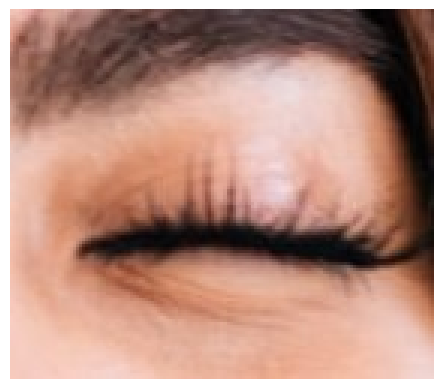

1/1 [==============================] - 0s 56ms/step
Predicted Label: 2


In [178]:
plt.imshow(plt.imread(r"train/Closed/_101.jpg"))
plt.title('')
plt.axis('off')
plt.show()

prediction = model.predict([prepare(r"train/Closed/_101.jpg")])
print("Predicted Label:", np.argmax(prediction))


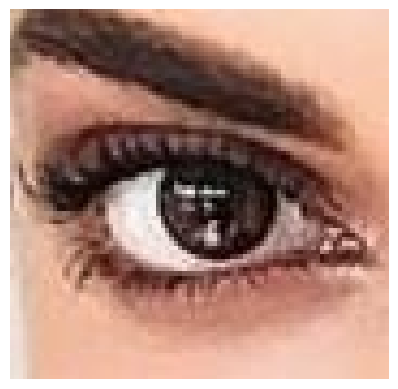

1/1 [==============================] - 0s 63ms/step
Predicted Label: 3


In [177]:
plt.imshow(plt.imread(r"train/Open/_1.jpg"))
plt.title('')
plt.axis('off')
plt.show()


prediction = model.predict([prepare(r"train/Open/_1.jpg")])
print("Predicted Label:", np.argmax(prediction))


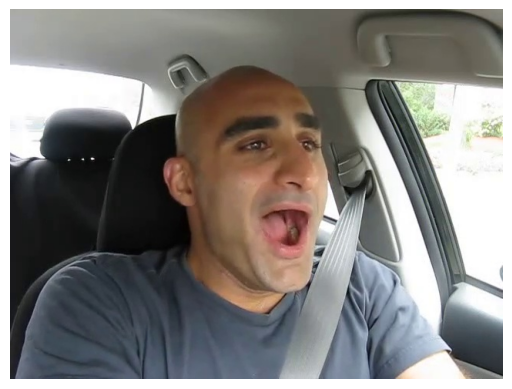

1/1 [==============================] - 0s 98ms/step
Predicted Label: 0


In [176]:
plt.imshow(plt.imread(r"train/yawn/312.jpg"))
plt.title('')
plt.axis('off')
plt.show()


prediction = model.predict([prepare(r"train/yawn/312.jpg")])
print("Predicted Label:", np.argmax(prediction))

